# Fit

Load modules:

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

## Using nonlinear least square

A least square problem can be viewed as an optimization problem with the objective function $g(\beta) = \sum_{i=0}^{m} r_i(\beta)^{2} = \| r(\beta) \|^{2}$, where $r(\beta)$ is a vector with the residuals $r_i(\beta) = y_i - f(x_i, \beta)$ for a set of $m$ observations $(x_i, y_i)$. Here $\beta$ is a vector of unknown parameters that specifies the function $f(x, \beta)$. If this problem is nonlinear in the parameters $\beta$, it is known as a nonlinear least square problem.

We can use a multivariate optimization technique such as Newton's method. However, this nonlinear least square optimization problem has a specific structure and can be solved using the Levenberg-Marquardt method.

In SciPy the function `optimize.leastsq` provides a nonlinear least square solver that uses Levenberg-Marquardt method. To illustrate consider a nonlinear model on the form $f(x, \beta) = \beta_0 + \beta_1 \exp{(-\beta_2 x^2)}$ and a set of observations $(x_i, y_i)$. The observations are simulated as random noise added to the true values.

In [14]:
beta = (0.25, 0.75, 0.5)

In [15]:
def f(x, b0, b1, b2):
    return b0 + b1 * np.exp(-b2 * x**2)

In [16]:
xdata = np.linspace(0, 5, 50)

In [17]:
y = f(xdata, *beta)

In [18]:
ydata = y + 0.05 * np.random.randn(len(xdata))

In [19]:
def g(beta):
    return ydata - f(xdata, *beta)

In [20]:
beta_start = (1, 1, 1)

In [21]:
%time beta_opt, beta_conv = optimize.leastsq(g, beta_start)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 50.8 ms


In [22]:
beta_opt

array([0.25396863, 0.78301316, 0.56626463])

Text(0,0.5,'$f(x, \\beta)$')

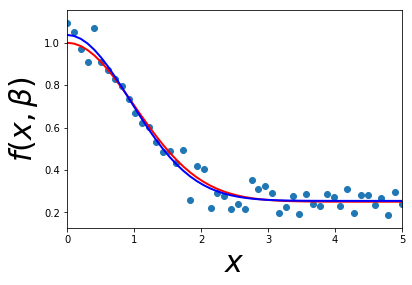

In [23]:
fig, ax = plt.subplots()
ax.scatter(xdata, ydata)
ax.plot(xdata, y, 'r', lw=2)
ax.plot(xdata, f(xdata, *beta_opt), 'b', lw=2)
ax.set_xlim(0, 5)
ax.set_xlabel(r"$x$", fontsize=30)
ax.set_ylabel(r"$f(x, \beta)$", fontsize=30)


## Robust linear estimator fitting


Here a sine function is fit with a polynomial of order 3, for values
close to zero.

Robust fitting is demoed in different situations:

- No measurement errors, only modelling errors (fitting a sine with a
  polynomial)

- Measurement errors in X

- Measurement errors in y

The median absolute deviation to non corrupt new data is used to judge
the quality of the prediction.

What we can see that:

- RANSAC is good for strong outliers in the y direction

- TheilSen is good for small outliers, both in direction X and y, but has
  a break point above which it performs worse than OLS.

- The scores of HuberRegressor may not be compared directly to both TheilSen
  and RANSAC because it does not attempt to completely filter the outliers
  but lessen their effect.




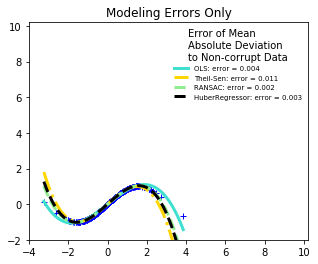

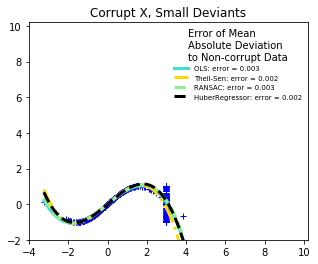

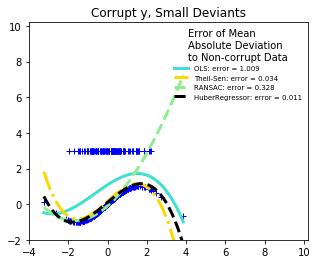

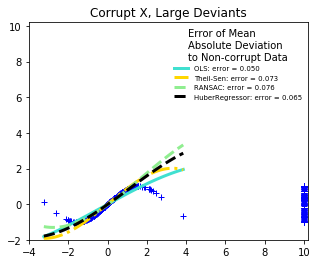

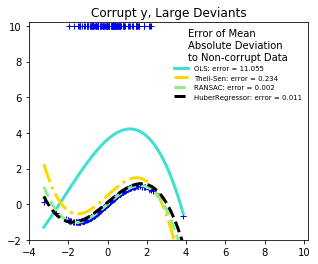

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

np.random.seed(42)

X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X[:, np.newaxis]

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('RANSAC', RANSACRegressor(random_state=42)),
              ('HuberRegressor', HuberRegressor())]
colors = {'OLS': 'turquoise', 'Theil-Sen': 'gold', 'RANSAC': 'lightgreen', 'HuberRegressor': 'black'}
linestyle = {'OLS': '-', 'Theil-Sen': '-.', 'RANSAC': '--', 'HuberRegressor': '--'}
lw = 3

x_plot = np.linspace(X.min(), X.max())
for title, this_X, this_y in [
        ('Modeling Errors Only', X, y),
        ('Corrupt X, Small Deviants', X_errors, y),
        ('Corrupt y, Small Deviants', X, y_errors),
        ('Corrupt X, Large Deviants', X_errors_large, y),
        ('Corrupt y, Large Deviants', X, y_errors_large)]:
    plt.figure(figsize=(5, 4))
    plt.plot(this_X[:, 0], this_y, 'b+')

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(x_plot, y_plot, color=colors[name], linestyle=linestyle[name],
                 linewidth=lw, label='%s: error = %.3f' % (name, mse))

    legend_title = 'Error of Mean\nAbsolute Deviation\nto Non-corrupt Data'
    legend = plt.legend(loc='upper right', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)
plt.show()